In [1]:
import pandas as pd

DATA_DIR = 'data'

# Loading the data from the provided files
movies_df_path = f'{DATA_DIR}/movies_df.xlsx'
ratings_df_path = f'{DATA_DIR}/train_ratings.csv'
original_movies_path = f'{DATA_DIR}/movies.csv'

# Reading the data from the files
movies_df = pd.read_excel(movies_df_path)
ratings_df = pd.read_csv(ratings_df_path)
original_movies_df = pd.read_csv(original_movies_path)

In [2]:
# Merging the datasets on 'movieId'
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

<hr color="#f0c6c6"/>
<h2><font color="#f0c6c6">Importance of Numerical Features</font></h3>

<font color="#a5adcb">
    We'll first try to visualize and understand the importance of our numerical features
</font>
<br/>
<font color="#b8c0e0">
    We'll look at 2 things, the Pearson Correlation & The mutual information, between the numerical features of a movie,
    and the rating given to it.
</font>
<br/>
<font color="#cad3f5">
    After that we'll train a random forest regressor to try to predict the rating given to the movie by a user by just using the numerical features,
    from there we'll also get the feature importance by using model.feature_importances_
    <br/>
    We'll also print the RMSE.
</font>

<hr color="#f0c6c6"/>

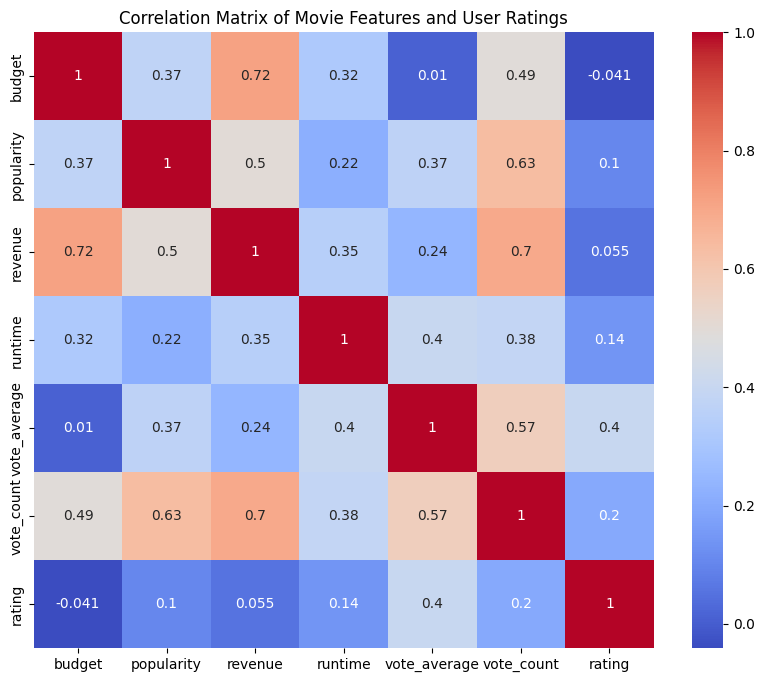

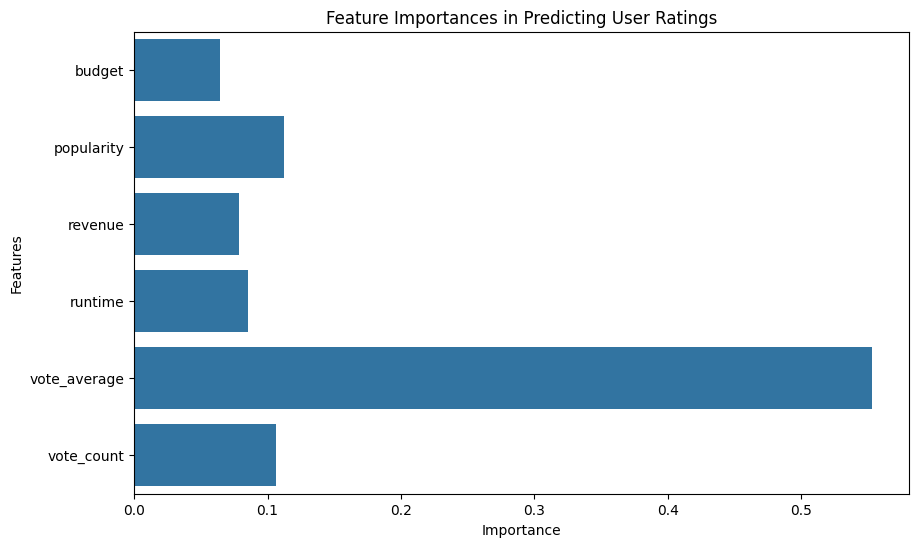

(0.9641153649910522,
 array([0.06424113, 0.11247729, 0.07823586, 0.08566799, 0.55332578,
        0.10605196]))

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Selecting numerical features for correlation analysis
numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'rating']

# Calculating the correlation matrix
correlation_matrix = merged_df[numerical_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Movie Features and User Ratings')
plt.show()

# Preparing data for feature importance analysis
# Dropping non-numerical and unnecessary columns
feature_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
X = merged_df[feature_columns]
y = merged_df['rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculating feature importances
feature_importances = rf_model.feature_importances_

# Predicting on the test set
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Creating a bar chart for feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_columns)
plt.title('Feature Importances in Predicting User Ratings')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

np.sqrt(mse), feature_importances


In [4]:
from sklearn.feature_selection import mutual_info_regression

# Selecting numerical features for mutual information analysis
numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Extracting the numerical features from the merged dataset
numerical_data = merged_df[numerical_features]

# Calculating mutual information
# Since mutual information requires non-null values, we will fill any NaNs with 0
numerical_data_filled = numerical_data.fillna(0)
mi = mutual_info_regression(numerical_data_filled, merged_df['rating'])
mi_results = dict(zip(numerical_features, mi))

# Sorting features by their mutual information with the rating
sorted_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted mutual information values
sorted_mi


[('vote_average', 0.12878128817763468),
 ('popularity', 0.12116384709827699),
 ('revenue', 0.11882332663489592),
 ('vote_count', 0.10560880869688738),
 ('runtime', 0.02711122959289014),
 ('budget', 0.026433590641231852)]

/var/folders/jt/f2yqrnv562q34hfjkkskqwzw0000gn/T/ipykernel_5057/1696086740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mi_results.values()), y=list(mi_results.keys()), palette="viridis")


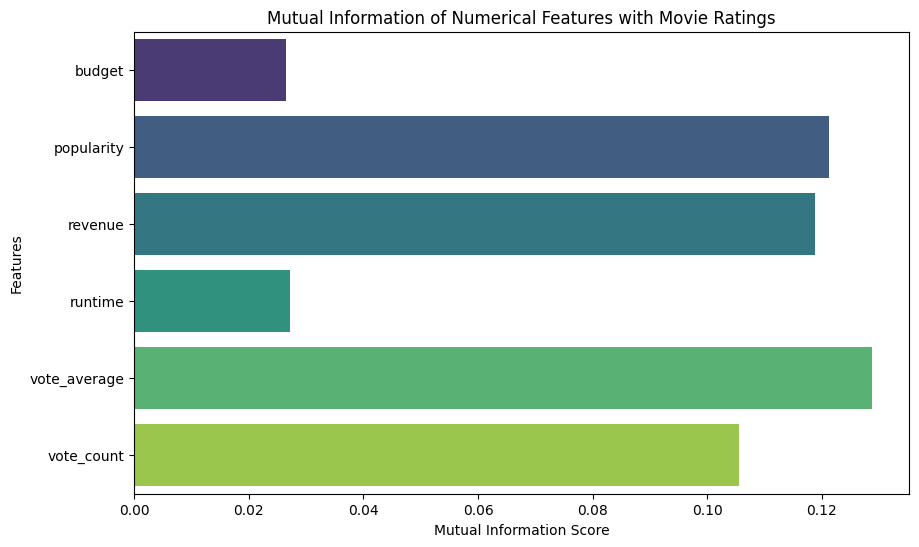

In [5]:
# Visualizing the mutual information results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(mi_results.values()), y=list(mi_results.keys()), palette="viridis")
plt.title('Mutual Information of Numerical Features with Movie Ratings')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

<hr color="#f0c6c6"/>
<h2><font color="#f0c6c6">Importance of Categorical Features</font></h3>

<font color="#a5adcb">
    Now we move onto our categorical features. Of which we have two:
</font>
</br>

- Tags

- Genres

<br/>

<hr color="#f0c6c6"/>

In [6]:
import ast

# Function to extract genres from the 'tags' column
def extract_genres(tags_str):
    try:
        tags_list = ast.literal_eval(tags_str)
        return [tag for tag in tags_list if tag.isalpha()] # Selecting only alphabetic tags as genres
    except:
        return []

# Applying the function to the 'tags' column
merged_df['genres'] = merged_df['tags'].apply(extract_genres)


In [30]:
from collections import Counter

# Counting the frequency of each genre
genre_counts = Counter([genre for sublist in merged_df['genres'] for genre in sublist])

# Selecting the top 10 most common genres
top_genres = [genre for genre, count in genre_counts.most_common(20)]

# Function to filter only top genres in each movie's genre list
def filter_top_genres(genres_list):
    return [genre for genre in genres_list if genre in top_genres]

# Applying the function to the 'genres' column
merged_df['top_genres'] = merged_df['genres'].apply(filter_top_genres)

In [31]:
one_hot_encoded = pd.get_dummies(merged_df['top_genres'].explode()).groupby(level=0).sum()
merged_df_with_top_genres = pd.concat([merged_df, one_hot_encoded], axis=1)

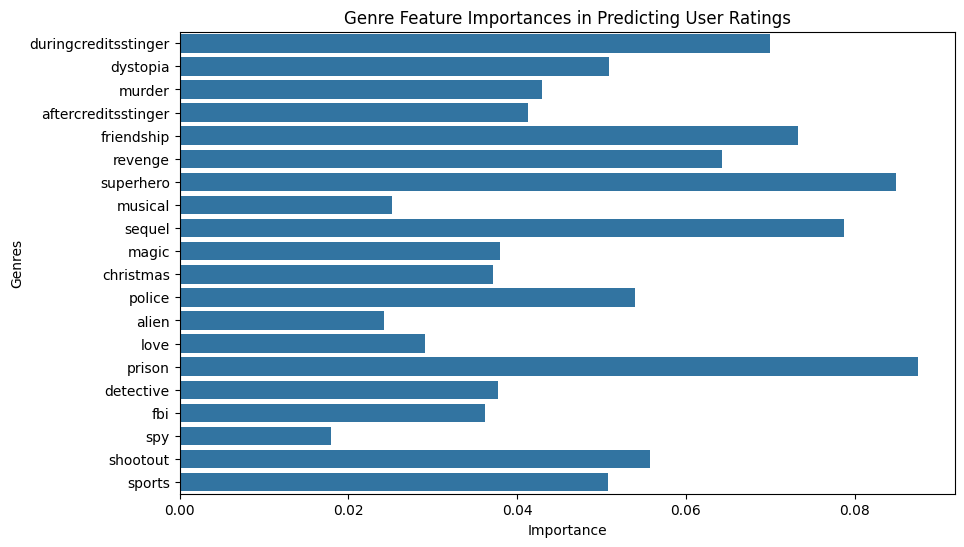

(1.0256525183235041,
 array([0.06998497, 0.05092266, 0.04300002, 0.04134623, 0.07327286,
        0.0642403 , 0.08495792, 0.02521829, 0.07879114, 0.03797858,
        0.03716906, 0.05396836, 0.02421269, 0.02908613, 0.08746328,
        0.03777721, 0.03622998, 0.01790653, 0.0557435 , 0.05073029]))

In [32]:
# Preparing data for genre importance analysis
X_genres = merged_df_with_top_genres[top_genres]
y_genres = merged_df_with_top_genres['rating']

# Splitting the data into training and testing sets for genres
X_train_genres, X_test_genres, y_train_genres, y_test_genres = train_test_split(X_genres, y_genres, test_size=0.3, random_state=42)

# Training a Random Forest Regressor for genres
rf_model_genres = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_genres.fit(X_train_genres, y_train_genres)

# Calculating feature importances for genres
genre_feature_importances = rf_model_genres.feature_importances_

# Predicting on the test set for genres
y_pred_genres = rf_model_genres.predict(X_test_genres)
mse_genres = mean_squared_error(y_test_genres, y_pred_genres)

# Creating a bar chart for genre feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_feature_importances, y=top_genres)
plt.title('Genre Feature Importances in Predicting User Ratings')
plt.xlabel('Importance')
plt.ylabel('Genres')
plt.show()

np.sqrt(mse_genres), genre_feature_importances


In [33]:
# add the merged_df the genres column of original_movies_df and name it original_genres
original_genres = original_movies_df[['movieId', 'genres']]
merged_df = merged_df.merge(original_genres, on='movieId')

In [35]:
# rename genres_x to genres
# rename genres_y to original_genres
merged_df.rename(columns={'genres_x': 'genres', 'genres_y': 'original_genres'}, inplace=True)

In [36]:
merged_df['original_genres'] = merged_df['original_genres'].apply(lambda x: x.split('|'))

In [37]:
# any NaN in genres column?
merged_df['original_genres'].isna().sum()

0

In [39]:
one_hot_encoded = pd.get_dummies(merged_df['original_genres'].explode()).groupby(level=0).sum()
merged_df_with_original_genres = pd.concat([merged_df, one_hot_encoded], axis=1)

In [40]:
merged_df_with_original_genres.shape

(80546, 38)

In [42]:
# Preparing data for genre importance analysis
X_genres = merged_df_with_original_genres[one_hot_encoded.columns.tolist()]
y_genres = merged_df_with_original_genres['rating']

# Splitting the data into training and testing sets for genres
X_train_genres, X_test_genres, y_train_genres, y_test_genres = train_test_split(X_genres, y_genres, test_size=0.3, random_state=42)

# Training a Random Forest Regressor for genres
rf_model_genres = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_genres.fit(X_train_genres, y_train_genres)

# Calculating feature importances for genres
genre_feature_importances = rf_model_genres.feature_importances_

genre_feature_importances


array([0.00017036, 0.0768618 , 0.06159595, 0.05396932, 0.04492177,
       0.05786092, 0.06085671, 0.01097952, 0.14840196, 0.05643883,
       0.0092527 , 0.043917  , 0.04062676, 0.03929478, 0.05902001,
       0.05839681, 0.06349723, 0.05853822, 0.0336221 , 0.02177725])

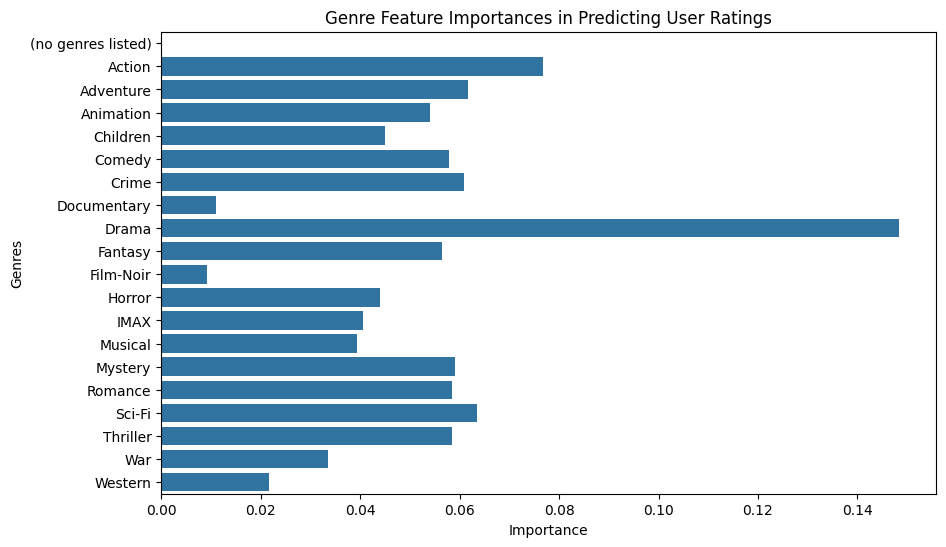

(0.9977739711218242,
 array([0.00017036, 0.0768618 , 0.06159595, 0.05396932, 0.04492177,
        0.05786092, 0.06085671, 0.01097952, 0.14840196, 0.05643883,
        0.0092527 , 0.043917  , 0.04062676, 0.03929478, 0.05902001,
        0.05839681, 0.06349723, 0.05853822, 0.0336221 , 0.02177725]))

In [44]:
# Predicting on the test set for genres
y_pred_genres = rf_model_genres.predict(X_test_genres)
mse_genres = mean_squared_error(y_test_genres, y_pred_genres)

# Creating a bar chart for genre feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_feature_importances, y=one_hot_encoded.columns.tolist())
plt.title('Genre Feature Importances in Predicting User Ratings')
plt.xlabel('Importance')
plt.ylabel('Genres')
plt.show()

np.sqrt(mse_genres), genre_feature_importances

<hr color="#f0c6c6"/>
<h2><font color="#f0c6c6">Importance of Embeddings</font></h3>

<font color="#a5adcb">
    We now try to see how well a GradientBoostingRegressor would perform to predict the AVG movie rating, by only considering the overview embeddings we have.
</font>

</br>

<hr color="#f0c6c6"/>

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

movies_df['overview_embeddings'] = movies_df['overview_embeddings'].apply(eval)
# Assuming 'overview_embeddings' is a column of lists
# Convert the embeddings into a format suitable for model input
embeddings = np.stack(movies_df['overview_embeddings'].apply(np.array))

# Extract the target variable (ratings)
ratings = ratings_df.groupby('movieId')['rating'].mean()

# Merge ratings with embeddings
ratings_embeddings_df = pd.DataFrame(embeddings, index=movies_df['movieId'])
merged_df = ratings_embeddings_df.join(ratings, how='inner')

# Split the data into features (X) and target (y)
X = merged_df.drop('rating', axis=1)
y = merged_df['rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training a Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating the MSE
mse = mean_squared_error(y_test, y_pred)

In [60]:
# take the root and get the RMSE
np.sqrt(mse)

0.8408733881906546